In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
from matplotlib import pyplot

In [22]:
# Cargando el conjunto de Datos
df = pd.read_csv('DCOILWTICO.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['Fecha','WTI'])
df.head()

Fecha
2015-10-05;46    28.0
2015-10-06;48    53.0
2015-10-07;47    86.0
2015-10-08;49    46.0
2015-10-09;49    67.0
Name: WTI, dtype: float64

In [23]:
df.describe()

count    1510.000000
mean       49.364901
std        28.736918
min         0.000000
25%        25.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: WTI, dtype: float64

## Procesamiento de los Datos

In [26]:
Pasos=8

# convertir series en aprendizaje supervisado
def series_supervisada(datos, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(datos) is list else datos.shape[1]
    df = pd.DataFrame(datos)
    cols, nombres = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        nombres += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia de pronostico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            nombres += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            nombres += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # poner todo junto
    agg = pd.concat(cols, axis=1)
    agg.columns = nombres
    # eliminar los valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargar el dataset
valores = df.values
# asegurarse que todos los tados son float
valores = valores.astype('float32')
# normalización de los datos para la tanh
escalar = MinMaxScaler(feature_range=(-1, 1))
valores=valores.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
escalado = escalar.fit_transform(valores)
# frame como aprendizaje supervisado
reframed = series_supervisada(escalado, Pasos, 1)
reframed.head()

,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
8,-0.434343,0.070707,0.737374,-0.070707,0.353535,-0.818182,0.414141,0.272727,-0.232323
9,0.070707,0.737374,-0.070707,0.353535,-0.818182,0.414141,0.272727,-0.232323,-0.393939
10,0.737374,-0.070707,0.353535,-0.818182,0.414141,0.272727,-0.232323,-0.393939,0.838384
11,-0.070707,0.353535,-0.818182,0.414141,0.272727,-0.232323,-0.393939,0.838384,0.696970
12,0.353535,-0.818182,0.414141,0.272727,-0.232323,-0.393939,0.838384,0.696970,-0.555556


#Dividir el conjunto de Entrenamiento y Validación

In [28]:
valores = reframed.values
n_dias_entrenamiento = 1095 - (30+Pasos)
entrenamiento = valores[:n_dias_entrenamiento, :]
validacion = valores[n_dias_entrenamiento:, :]
# dividir en entradas y salidas
x_entrenamiento, y_entrenamiento = entrenamiento[:, :-1], entrenamiento[:, -1]
x_val, y_val = validacion[:, :-1], validacion[:, -1]
# ajustar la entrada para que sea 3D [muestras, intervalos de tiempo, características]
x_entrenamiento = x_entrenamiento.reshape((x_entrenamiento.shape[0], 1, x_entrenamiento.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_entrenamiento.shape, y_entrenamiento.shape, x_val.shape, y_val.shape)

(1057, 1, 8) (1057,) (29, 1, 8) (29,)


# Creamos la RNN con Regularización L2

In [29]:
def crear_modeloLSTM():
    model = Sequential() 
    model.add(LSTM(Pasos, return_sequences=True, input_shape=(1,Pasos),activation='tanh'))
    model.add(LSTM(6, return_sequences=True, activation='tanh',kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(LSTM(4, return_sequences=True, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [30]:
Epocas=60

modelo = crear_modeloLSTM()

history=modelo.fit(x_entrenamiento,y_entrenamiento,epochs=Epocas,validation_data=(x_val,y_val),batch_size=Pasos)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 8)              544       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 6)              360       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              176       
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 1,085
Trainable params: 1,085
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
133/133 [==============================] - 7s 14ms/step - loss: 0.6800 - mse: 0.3472 - val_loss: 0.4752 - val

# Visualización de los Resultados

29


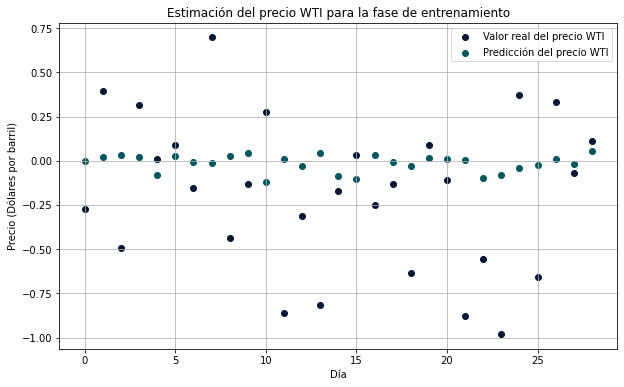

In [31]:
results=modelo.predict(x_val)
print( len(results) )
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_val)),y_val,color="#031634",label="Valor real del precio WTI")
plt.scatter(range(len(results)),results,color="#03565E",label="Predicción del precio WTI")
plt.title('Estimación del precio WTI para la fase de entrenamiento')
plt.xlabel('Día')
plt.ylabel('Precio (Dólares por barril)')
plt.legend()
plt.grid()
plt.show()

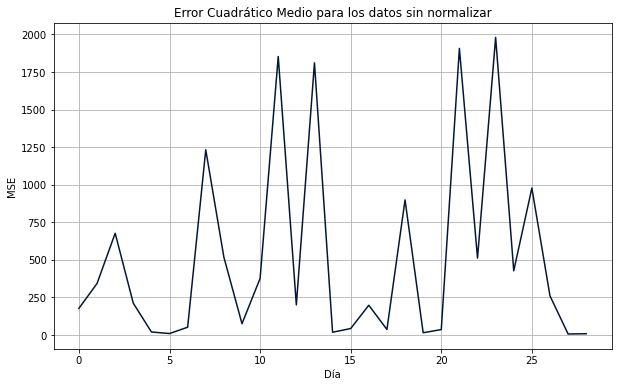

In [32]:
n=len(results)
MSE=np.zeros(n)
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inversa = escalar.inverse_transform(compara.values)

compara2 = pd.DataFrame(inversa)
compara2.columns = ['real', 'prediccion']
MSEsum=0
for i in range(0,len(results)):
  MSE[i] = (compara2['real'][i] - compara2['prediccion'][i])**2
  MSEsum = np.sum(MSE)/n
plt.figure(figsize=(10,6))
plt.plot(range(len(results)),MSE, color="#031634")
plt.title('Error Cuadrático Medio para los datos sin normalizar')
plt.xlabel('Día')
plt.ylabel('MSE')
plt.grid()
plt.show()

In [34]:
print('El MSE es de %0.3f' % MSEsum)

El MSE es de 513.136


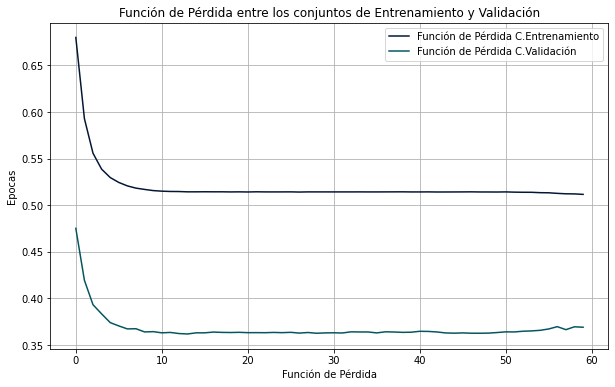

In [33]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color="#031634",label="Función de Pérdida C.Entrenamiento")
plt.plot(history.history['val_loss'], color="#03565E" ,label="Función de Pérdida C.Validación")
plt.title('Función de Pérdida entre los conjuntos de Entrenamiento y Validación')
plt.xlabel('Función de Pérdida')
plt.ylabel('Epocas')
plt.legend()
plt.grid()
plt.show()

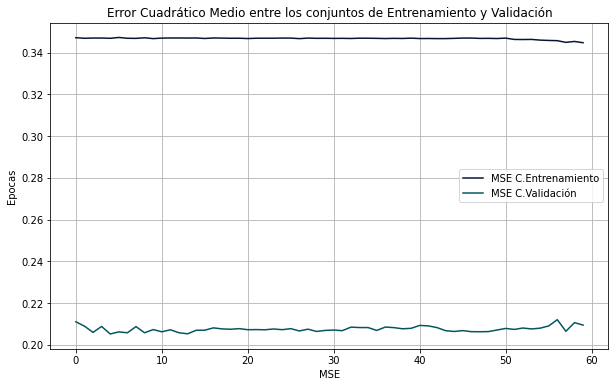

In [35]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mse'], color="#031634", label="MSE C.Entrenamiento")
plt.plot(history.history['val_mse'], color="#03565E", label="MSE C.Validación")
plt.title('Error Cuadrático Medio entre los conjuntos de Entrenamiento y Validación')
plt.xlabel('MSE')
plt.ylabel('Epocas')
plt.legend()
plt.grid()
plt.show()

In [36]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inversa = escalar.inverse_transform(compara.values)

compara2 = pd.DataFrame(inversa)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,36.000000,49.315678,-13.315678
1,69.000000,50.484760,18.515240
2,24.999998,51.018593,-26.018595
3,65.000000,50.457451,14.542549
4,49.999996,45.538788,4.461208
5,54.000000,50.931927,3.068073
6,42.000000,49.187824,-7.187824
7,84.000000,48.892075,35.107925
8,27.999998,50.759514,-22.759516
9,43.000000,51.652954,-8.652954


In [37]:
compara2.describe()

,real,prediccion,diferencia
count,29.000000,29.000000,29.000000
mean,40.620689,48.811123,-8.190429
std,21.369894,2.384853,21.493809
min,1.000001,43.597649,-44.499046
25%,24.999998,47.984360,-22.759516
50%,43.000000,49.315678,-6.045895
75%,54.000000,50.484760,4.461208
max,84.000000,52.123600,35.107925


# Pronóstico

In [38]:
ultimosDias = df['2021-07-24':'2020-08-03']
ultimosDias

Fecha
2020-07-24;41    23.0
2020-07-27;41    46.0
2020-07-28;40    89.0
2020-07-29;41    13.0
2020-07-30;39    85.0
2020-07-31;40    10.0
Name: WTI, dtype: float64

# Preparamos los datos para el Test

In [ ]:
valores = ultimosDias.values
valores= valores.astype('float32')
# normalizar
valores=valores.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
escalado = escalar.fit_transform(valores)
reframed = series_supervisada(escalado, Pasos, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t)


In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(0, 1, 8)


array([], shape=(0, 1, 8), dtype=float32)